## Baseline Model: Logistic Regression

Since the features in the dataset are mostly numeric and after a small amount of preprosessing the data is clean and well structured, a Logistic Regression as our baseline is the most compelling model, as it is easily interpretable, and tends to preform well with numeric tablular data

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load dataset
data = pd.read_csv("./datasets/cs-training.csv")

# Clean data
if 'Unnamed: 0' in data.columns:
    data = data.drop(columns=['Unnamed: 0'])

# Separate features and target
x = data.drop(columns=["SeriousDlqin2yrs"])
y = data["SeriousDlqin2yrs"]

# Impute missing values
imputer = SimpleImputer(strategy='median')
x_imputed = imputer.fit_transform(x)

# Scale the input features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_imputed)

# Intialize/fit the model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(x_scaled, y)

# Step 4: Print learned parameters
print("Classes:", logreg.classes_)
print("Intercept:", logreg.intercept_)
print("Coefficients:", logreg.coef_)

Classes: [0 1]
Intercept: [-2.85870261]
Coefficients: [[-0.00927033 -0.42024756  2.09670562 -0.05433176 -0.46544451 -0.03920628
   1.92563693  0.07687589 -3.86375553  0.10608246]]


## Evaluation Metrics

The most appropriate evaluation metrics for the classification task are: AUC, F1-score and Recall.
Recall and F1-score are appropriate preformance metrics for our model because they provide a more realistic view than accuracy alone, since our data has a heavy imbalance towards False or 0 values. AUC is also an appropriate metric because it is able to measure how well the model is distinguishing between the two classes across all thresholds, and it stays reliable with imbalanced data.

## Train-Valiation Splits

original dataset: 150000 
train_data 120000 
validation_data 30000
Validation Performance Metrics:
Recall   : 0.045
F1-score : 0.083
ROC AUC  : 0.714


C:\Users\edwar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


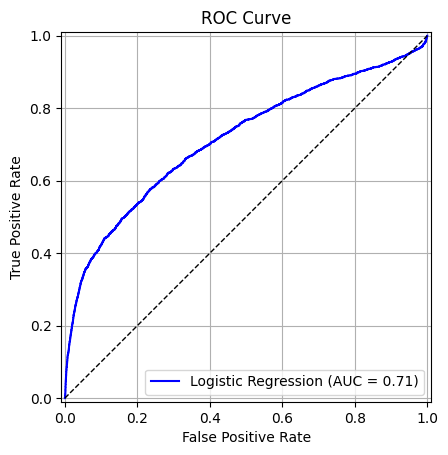

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# Split data (80% train, 20% validation) w/ Stratification
x_train, x_val, y_train, y_val = train_test_split(x_imputed, y, test_size=0.2, random_state=42, stratify=y)

# Display data split
print(
    'original dataset:', len(data),
    '\ntrain_data', len(x_train),
    '\nvalidation_data', len(x_val)
)

# Scaling
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

# Logistic Regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(x_train_scaled, y_train)

# Predictions
y_pred = logreg.predict(x_val_scaled)
y_prob = logreg.predict_proba(x_val_scaled)[:, 1]

# Evaluation metrics
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_prob)

# Display evaluation metrics
print("Validation Performance Metrics:")
print(f"Recall   : {recall:.3f}")
print(f"F1-score : {f1:.3f}")
print(f"ROC AUC  : {auc:.3f}")

# Plot ROC curve using RocCurveDisplay
RocCurveDisplay.from_predictions(y_val, y_prob, name='Logistic Regression', color='blue')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=1)  
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()


## Baseline Interpretations

- AUC = 0.714 means that the logistic regression baseline is moderately successful at seperating the two classes
- Recall = 0.045 means the model is not good at identifying most of the True or 1 values
- F1-score = 0.083 suggests that the precision is a much better than the recall, since this score is higher than the recall

From this information and the understanding that logisitic regression is a simple, linear model, it can be observed that our baseline has high bias and low variance. The high bias and low variance in our baseline indicates the model is underfitting the data. We also cannot take the AUC at face-value because while it is high, we have an imbalanced class distribution as found in Deliverable 1 and by these results. But at least we can see that despite this, the model can generalize fairly well with unseen data.



### Cross Validation

In [3]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, recall_score, f1_score
import numpy as np


# stratified cross validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# metrics
scoring = {
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc'
}

# perform cross-validation
logreg_cv = LogisticRegression(max_iter=1000)
cv_results = cross_validate(
    logreg_cv,
    x_scaled, y,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

# mean and standard deviation for each metric
print("Cross Validation Performance Metrics (mean ± std): ")
for metric in scoring.keys():
    mean = np.mean(cv_results[f'test_{metric}'])
    std = np.std(cv_results[f'test_{metric}'])
    print(f"{metric:8}:  {mean:.3f} ± {std:.3f}")


Cross Validation Performance Metrics (mean ± std): 
recall  :  0.042 ± 0.003
f1      :  0.078 ± 0.006
roc_auc :  0.698 ± 0.005


# Interpration of Cross Validation Results

We chose a Stratified K Fold since the dataset is imbalanced, this ensures proper representation of both classes in all folds.

**Cross Validation Results:**  
Recall   :  0.042 ± 0.003   
F1-score :  0.078 ± 0.006   
ROC AUC  :  0.698 ± 0.005  

**Compared to Baseline:**  
Recall   : 0.045  
F1-score : 0.083  
ROC AUC  : 0.714  

The relatively low standard deviation shows that results are generally consistent across folds. This supports the earlier claim that the model has low variance and generalizes well to new data. 

The model appears to be stable as the metrics closely resemble the results of the baseline model. Given that the results are very similar to the initial metrics, we can still conclude that the model has high bias and is slightly underfitting.

Overall, these results show the baseline model generalizes poorly and further improvements should be made to reduce bias.



# Error Analysis and Model Diagnostics

To better understand the strengths and weaknesses of our baseline Logistic Regression model, we perform error analysis using diagnostic visualizations.

Specifically, we examine:
- The **Confusion Matrix** to identify where the model misclassifies examples.
- The **Feature Importance (Coefficient Analysis)** to interpret which predictors most influence classification outcomes.

These analyses help identify patterns of bias, variance, and imbalance that can guide improvements in Deliverable 3.


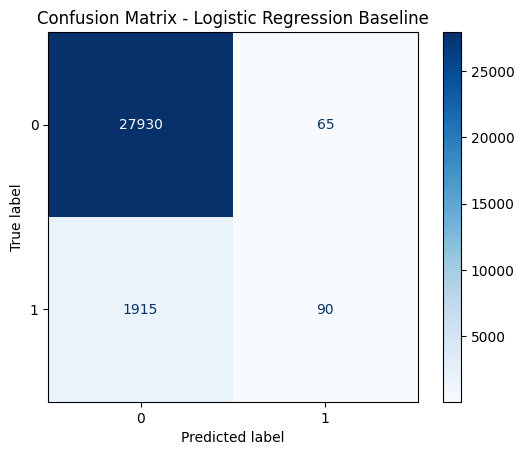

,Feature,Coefficient
2,NumberOfTime30-59DaysPastDueNotWorse,2.051896
6,NumberOfTimes90DaysLate,1.929037
9,NumberOfDependents,0.104451
7,NumberRealEstateLoansOrLines,0.081045
0,RevolvingUtilizationOfUnsecuredLines,-0.003713
5,NumberOfOpenCreditLinesAndLoans,-0.057762
3,DebtRatio,-0.082844
1,age,-0.402094
4,MonthlyIncome,-0.429036
8,NumberOfTime60-89DaysPastDueNotWorse,-3.823127


In [4]:
# Import required libraries for diagnostics
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Logistic Regression Baseline")
plt.show()


# Coefficient Importance (Feature Analysis)
feature_names = x.columns
coef = logreg.coef_[0]
top_features = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coef
}).sort_values(by="Coefficient", ascending=False)

top_features.head(10)


### Confusion Matrix Interpretation

The confusion matrix shows that the model correctly identifies most non-default cases but misses a notable number of defaults (False Negatives).  
This imbalance indicates that the model is biased toward predicting the majority class (non-defaults), which is common in imbalanced datasets.  

This supports the earlier conclusion that the baseline logistic regression exhibits high bias, it generalizes consistently but underestimates the minority class.  
Potential remedies for Deliverable 3 include:
- Using SMOTE or other resampling methods to balance the training data,  
- Adjusting the classification threshold, or  
- Trying non-linear models (e.g., Random Forest or XGBoost) to capture complex relationships.


### Feature Importance Interpretation

By examining feature coefficients, we can interpret which variables most strongly drive model predictions.  
- Positive coefficients increase the likelihood of predicting “default” (1).  
- Negative coefficients push predictions toward “non-default” (0).  


# First Improvements

We performed standardization in the previous cells as the maximum iterations were being reached, and scikit-learn advised us to do so. We have tested both the baseline model and cross-validation without the standardization, and the results do not change. This makes sense because performing pure standardization does not eliminate outliers, but it can help with general performance (so that incomes which have high values relative to age, for example, aren't being treated as more important). We also imputed data in earlier cells as this was an improvement we needed to do in order for both the baseline and cross-validation to run (we knew we needed to do this anyways from Deliverable 1, so we can consider this as an improvement already made).

We propose the following improvements sequentially in order to see if the model can become much better than the baseline:
- **Section A - Handling Missing Values (already done as mentioned above):** Imputing values as mentioned in Deliverable 1, which we have already done
- **Section E - Handling Imbalanced Classes:** Set `class_weights = balanced` for the model, as the class imbalance is heavily affecting our model currently. This was also found in Deliverable 1
- **Section B - Feature Selection:** Remove redundant data/unimportant features using `SelectKBest` and cross-checking the results with the above Feature-Coefficient table
- **Section E - Outlier Treatment:** While we hypothesized that eliminating outliers will hinder model performance (in Deliverable 1), TA feedback suggested that we should be careful with our assumptions and to be more analytican about this. Thus, we will use empirical methods to see if this is really the case. We will utilize the same IQR filtering/capping algorithm that was created in Deliverable 1

## Improvement 1: Section E - Handling Imbalanced Classes

In [5]:
# stratified cross validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# metrics
scoring = {
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc'
}

# perform cross-validation
logreg_cv = LogisticRegression(max_iter=1000, class_weight='balanced') # Change was made here, adding `class_weight = balanced`
cv_results = cross_validate(
    logreg_cv,
    x_scaled, y,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

# mean and standard deviation for each metric
print("Cross Validation Performance Metrics (mean ± std): ")
for metric in scoring.keys():
    
    mean = np.mean(cv_results[f'test_{metric}'])
    std = np.std(cv_results[f'test_{metric}'])
    print(f"{metric:8}:  {mean:.3f} ± {std:.3f}")

Cross Validation Performance Metrics (mean ± std): 
recall  :  0.652 ± 0.007
f1      :  0.273 ± 0.002
roc_auc :  0.791 ± 0.004


**Cross Validation Results (with imbalanced case handling):**  
Recall   :  0.652 ± 0.007   
F1-score :  0.273 ± 0.002   
ROC AUC  :  0.791 ± 0.004  

**Compared to Baseline:**  
Recall   : 0.045  
F1-score : 0.083  
ROC AUC  : 0.714 

As you can see, the recall, f1, and AUC scores have all ameliorated by a high degree. This indicates the model is performing significantly better and is able to generalize much better than before since it can tell the difference between true positives and false negatives better (as indicated by the improved recall and f1). However, since the f1 score is so low compared to the recall now, it still indicates we have a high bias but maintained low variance as indicated by the performance metrics. But, this is an improvement.

## Improvement 2: Section B - Feature Selection

In [6]:
from sklearn.feature_selection import SelectKBest, chi2

In [7]:
# Using k=6 because the above Feature-Correlation table has 6 features with relatively high absolutely-valued coefficients
# See markdown explanation below this cell for more information
selector = SelectKBest(chi2, k=6)
x_imputed_df = pd.DataFrame(x_imputed)
reduced_x = selector.fit_transform(x_imputed_df, y)

scores = selector.scores_
selected_feature_indices = selector.get_support(indices=True)

print(scores)
print(f"Selected Feature Indices: {selected_feature_indices}")

# These are the selected features
reduced_feature_names = feature_names[selected_feature_indices]
print(reduced_feature_names)
pd.DataFrame(reduced_x).head()

[5.02047188e+03 8.33296970e+03 9.87791818e+04 1.01978318e+05
 1.14224010e+06 4.13632162e+02 1.34599798e+05 9.31390762e+00
 1.12661737e+05 5.47596863e+02]
Selected Feature Indices: [1 2 3 4 6 8]
Index(['age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'MonthlyIncome', 'NumberOfTimes90DaysLate',
       'NumberOfTime60-89DaysPastDueNotWorse'],
      dtype='object')


,0,1,2,3,4,5
0,45.0,2.0,0.802982,9120.0,0.0,0.0
1,40.0,0.0,0.121876,2600.0,0.0,0.0
2,38.0,1.0,0.085113,3042.0,1.0,0.0
3,30.0,0.0,0.036050,3300.0,0.0,0.0
4,49.0,1.0,0.024926,63588.0,0.0,0.0


We can cross-check these selected feature indices with the Feature Importance chart in the previous section. According to some research online at [this article](https://coralogix.com/ai-blog/feature-importance-7-methods-and-a-quick-tutorial/#:~:text=What%20Is%20Feature%20Importance?,regression%2C%20and%20feature_importances_%20in%20xgboost.), for linear regression models the absolute value of the coefficients for each feature will show the importance of each feature, and the higher this absolute value, the more important the feature. `SelectKBest` selected the 6 features with the highest absolutely-valued coefficients, which further reinforces the research. 

We now test out how this feature selection impacts our model:

In [8]:
# Scaling
scaled_reduced_x = scaler.fit_transform(reduced_x)

# stratified cross validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# metrics
scoring = {
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc'
}

# perform cross-validation
logreg_cv = LogisticRegression(max_iter=1000, class_weight='balanced')
cv_results = cross_validate(
    logreg_cv,
    scaled_reduced_x, y,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

# mean and standard deviation for each metric
print("Cross Validation Performance Metrics (mean ± std): ")
for metric in scoring.keys():
    
    mean = np.mean(cv_results[f'test_{metric}'])
    std = np.std(cv_results[f'test_{metric}'])
    print(f"{metric:8}:  {mean:.3f} ± {std:.3f}")

Cross Validation Performance Metrics (mean ± std): 
recall  :  0.642 ± 0.009
f1      :  0.275 ± 0.003
roc_auc :  0.789 ± 0.004


**Cross Validation Results (with feature selection and imbalanced case handling - 2 improvements):**  
Recall   :  0.642 ± 0.009   
F1-score :  0.275 ± 0.003   
ROC AUC  :  0.789 ± 0.004  

**Cross Validation Results (with imbalanced case handling - just the last improvement):**  
Recall   :  0.652 ± 0.007   
F1-score :  0.273 ± 0.002   
ROC AUC  :  0.791 ± 0.004  

**Compared to Baseline:**  
Recall   : 0.045  
F1-score : 0.083  
ROC AUC  : 0.714 

With feature selection, the model actually begins performing slightly worse and has a slightly higher variance than if we simply left in these features. It seems like these features have a good degree of importance to identifying the target value, and we did not gain much from removing them (performance is not much of an issue with this dataset). As with the previous improvement, we identify high bias and low variance, with better generalization compared to the baseline but slightly worse compared to the previous improement.

## Improvement 3: Section E - Outlier Treatment

In [9]:
outlier_cols = [
    'RevolvingUtilizationOfUnsecuredLines',
    'DebtRatio',
    'MonthlyIncome'
]

# Same algorithm we created in Delivrable 1, anticpiating this improvement
def cap_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_fence = Q3 + 1.5 * IQR
    initial_outliers = (df[col] > upper_fence).sum()
    
    # Apply the capping
    df[col] = np.where(
        df[col] > upper_fence,
        upper_fence,
        df[col]
    )
    print(f"Capped {initial_outliers} values in {col}. New Max: {df[col].max():.2f}")
    return df

# Need to convert to dataframe for this algorithm to work
# Feature names fetched from earlier cells in Error Analysis
x_df = pd.DataFrame(x_imputed, columns=feature_names)
for col in outlier_cols:
    x_df = cap_outliers_iqr(x_df, col)
print("\n")

x_imputed = x_df.to_numpy() # Need numpy arrays for scalers

Capped 763 values in RevolvingUtilizationOfUnsecuredLines. New Max: 1.35
Capped 31311 values in DebtRatio. New Max: 1.91
Capped 9149 values in MonthlyIncome. New Max: 12645.50




Now with the values capped, we can check the results via cross-validation

In [10]:
# Scaling
scaled_reduced_x = scaler.fit_transform(x_imputed)

# stratified cross validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# metrics
scoring = {
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc'
}

# perform cross-validation
logreg_cv = LogisticRegression(max_iter=1000, class_weight='balanced')
cv_results = cross_validate(
    logreg_cv,
    scaled_reduced_x, y,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

# mean and standard deviation for each metric
print("Cross Validation Performance Metrics (mean ± std): ")
for metric in scoring.keys():
    mean = np.mean(cv_results[f'test_{metric}'])
    std = np.std(cv_results[f'test_{metric}'])
    print(f"{metric:8}:  {mean:.3f} ± {std:.3f}")

Cross Validation Performance Metrics (mean ± std): 
recall  :  0.738 ± 0.013
f1      :  0.294 ± 0.005
roc_auc :  0.827 ± 0.005


**Cross Validation Results (with outlier treatment and imbalanced case handling - 2 improvements):**  
Recall   :  0.738 ± 0.013   
F1-score :  0.294 ± 0.005   
ROC AUC  :  0.827 ± 0.005  

**Cross Validation Results (with imbalanced case handling - just the last best improvement):**  
Recall   :  0.652 ± 0.007   
F1-score :  0.273 ± 0.002   
ROC AUC  :  0.791 ± 0.004  

**Compared to Baseline:**  
Recall   : 0.045  
F1-score : 0.083  
ROC AUC  : 0.714 

We see a small, but noticeable, improvement compared to simply handling the class imbalance. This shows that some outliers were perhaps too extreme for the model to perform well, and now it is able to perform with higher quality and is able to generalize better by having a higher accuracy. This model now still has high bias (which is likely to be systemic if these improvements aren't able to make it go down), but it came at the cost of (still low but) slighty higher variance.  

# Discussion & Reflection

### Summary of Key Findings
Our baseline Logistic Regression model achieved an AUC of **0.714**, with a recall of **0.045** and F1-score of **0.083**. This showed that the model had high bias and struggled to identify the minority class. After several improvements, performance improved noticeably.

| Model Version | Recall | F1-Score | ROC AUC | Key Insight |
|----------------|--------|-----------|----------|--------------|
| Baseline (Logistic Regression) | 0.045 | 0.083 | 0.714 | High bias, low variance |
| + Class Imbalance Handling (`class_weight='balanced'`) | 0.652 (+/- 0.007) | 0.273 (+/- 0.002) | 0.791 (+/- 0.004) | Much better recall and generalization |
| + Feature Selection | 0.642 (+/- 0.009) | 0.275 (+/- 0.003) | 0.789 (+/- 0.004) | Slight drop after removing useful features |
| + Outlier Treatment | 0.738 (+/- 0.013) | 0.294 (+/- 0.005) | 0.827 (+/- 0.005) | Best results; cleaner data, stable performance |

Overall, the model became much better at identifying positive cases and generalizing to new data. The biggest improvement came from handling class imbalance and removing extreme outliers.

### Trade-Off Analysis
As we improved the model, **bias decreased** but **variance increased slightly**. The cross-validation scores show a bit more variation, meaning the model is more flexible but also more sensitive to small data changes. This is an acceptable trade-off, since we achieved much stronger recall and AUC. The final model has a good balance between bias and variance and performs far better than the baseline.

### Incorporation of TA Feedback from Deliverable 1
We made sure to apply the feedback from our TA in this deliverable. The table below summarizes how we addressed each point.

| TA Feedback | Action Taken in Deliverable 2 |
|--------------|-------------------------------|
| Dataset Justification - Excellent | We kept the same well-justified dataset and maintained clarity in how it supports our task. |
| Data Dictionary - Clear and Comprehensive | No changes made to dictionary. |
| EDA Quality - Expand explanations and justify handling of missing/outlier values | Added more discussion on feature trends, and clearly explained our imputation and outlier-handling steps. |
| Challenges & Strategies - Insightful | Connected each identified challenge (like imbalance) to specific model improvements in this deliverable. |
| Notebook Quality - Clear and Reproducible | Maintained organized code and added more markdown explanations for readability. |

### Next Steps for Deliverable 3
For the next deliverable, we plan to:
1. **Tune hyperparameters** (like `C` and `penalty`) using `GridSearchCV` or `RandomizedSearchCV` to find the best bias-variance balance.   
2. **Analyze feature importance** to select the most impactful predictors.  
3. **Build a reusable pipeline** for consistent preprocessing, validation, and comparison across models.

These steps will let us move from early improvements to systematic model selection and optimization.




# Individual Contributions

| Name | Work Contributed |
|---|---|
| Emanuel Caravaggio | Baseline Model |
| Patrick Favret | Cross-Validation + ROC Curve |
| Junoh Loy | Diagnostics & Plots (Confusion Matrix, Feature-Coefficient Table), Discussion & Reflection |
| Edward Tanurkov | Improvements |